In [1]:
%matplotlib inline
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import pandas as pd
import numpy as np
import glob
import json
import cv2
import glob
os.environ["OPENCV_LOG_LEVEL"]="SILENT"



## Inventory Processing

In [5]:
import os
import sys
from brails import Importer
from brails.types.image_set import ImageSet 


# sys.path.insert(1, "../../")

# This script needs a Google API Key to run.
# We suggest placing your API key in file apiKey.txt in the same directory as 
# this script if you plan to commit changes to this example. This way, you do 
# not risk accidentally uploading your API key (apiKey.txt is in .gitignore, 
# so you have work to do to get it uploaded)

apiKey = ""
if os.path.exists("apiKey.txt"):
    with open("apiKey.txt", "r") as file:
        apiKey = file.readline().strip()  # Read the first line and strip whitespace

# Create the importer:
importer = Importer()

# Select a region and create its RegionBoundary:
region_data = {"type": "locationName", "data": "Tiburon, CA"}
region_boundary_class = importer.get_class("RegionBoundary")
region_boundary_object = region_boundary_class(region_data)

# Get AssetInventory for buildings in the defined region via 
# USA_FootprintScraper:
print("Running USA_FootprintsScraper...")

usa_class = importer.get_class("USA_FootprintScraper")
usa_data = {"length": "ft"}
instance2 = usa_class(usa_data)
usa_inventory = instance2.get_footprints(region_boundary_object)

print("\nTotal number of assets detected using FEMA USA Structures data: "
      , len(usa_inventory.inventory))

# Subsample from the extracted assets to keep the image downloading step quick.
# Here, we are randomly sampling 15 buildings using a random seed value of 40:
small_inventory = usa_inventory.get_random_sample(15, 40)
print("Number of assets in the selected subset: ", 
      len(small_inventory.inventory))
 
# Get aerial imagery for the selected subset using GoogleSatellite:
google_satellite_class = importer.get_class("GoogleSatellite")
google_satellite = google_satellite_class()
images_satellite = google_satellite.get_images(small_inventory, "tmp/satellite/")

images_satellite.print()

# Get street level imagery for the selected subset using GoogleStreetview:
google_street_class = importer.get_class("GoogleStreetview")
google_input = {"apiKey": apiKey}
google_street = google_street_class(google_input)
images_street = google_street.get_images(small_inventory, "tmp/street/")
images_street.print()

#crop and zoom into the target house
filter_house = importer.get_class("HouseView")
filter_data={}
filter1 = filter_house(filter_data)
filter1.filter(images_street, "filtered_images")
images_street = ImageSet()
images_street.set_directory("filtered_images", True) #set directory that stores filtered images

True

In [7]:
'''
Purpose: Predict buillding attributes
'''

# import sys
# import importlib.util

#if importlib.util.find_spec("brails") is None:
# sys.path.insert(1,'../../')

GPT_API_KEY = ""
if os.path.exists("gptKey.txt"):
    with open("gptKey.txt", "r") as file:
        GPT_API_KEY = file.readline().strip()  # Read the first line and strip whitespace


print('NFLOOR_GPT PREDICTIONS')
my_class = importer.get_class('NFloorGPT')
my_classifier = my_class(GPT_API_KEY)
predictions = my_classifier.predict(images_street)
print(predictions)


NFLOOR_GPT PREDICTIONS
pred = none for key = 4, response -> I'm sorry, but I can't determine the number of stories of the house from the ima
pred = none for key = 8, response -> I'm unable to determine the number of stories from this image.
{1: 'two-story', 2: 'two-story', 3: 'one-story', 4: 'none', 5: 'one-story', 6: 'two-story', 7: 'one-story', 8: 'none', 9: 'one-story', 10: 'three-story', 11: 'one-story', 12: 'two-story'}


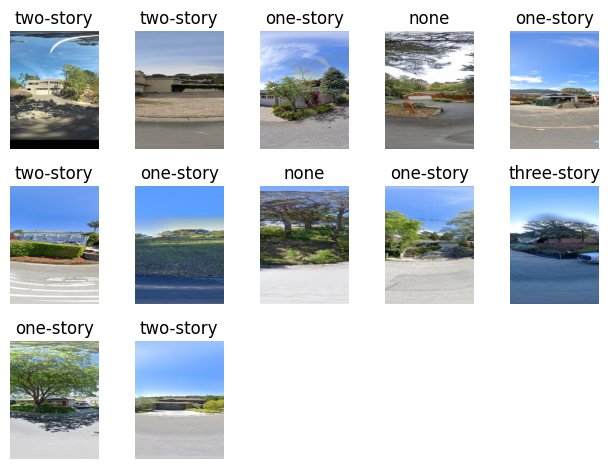

In [11]:
# RoofShape Classification
%matplotlib inline
plt.figure()
curr_dir = "tmp/street/"

for idx, (key, img) in enumerate(images_street.images.items()):
    filename = img.filename
    img_path = os.path.join(curr_dir, filename)
    img = mpimg.imread(img_path)    
    img = cv2.resize(img, (360, 480), interpolation = cv2.INTER_LINEAR)
    pred = predictions[key]
    plt.subplot(3, 5, idx+1)
    plt.imshow(img, cmap='gray')
    plt.title(pred)
    plt.axis('off')
plt.tight_layout()
plt.margins(0,0)
plt.show()